# SISTER CWL submission
***

In [153]:
import json
import os
import xml.etree.ElementTree as ET
import pandas as pd
import requests
import IPython
from itertools import groupby
import datetime as dt 
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from maap.maap import MAAP
maap = MAAP(maap_host="sister-api.imgspec.org")

In [154]:
def get_quicklook(job_id):
    result = maap.getJobResult(job_id)
    granule = result.outputs[0]
    return f'{granule}/{os.path.basename(granule)}.png'

### Load production list with scene URLs


In [155]:
scene_df = pd.read_csv('./sister_production_3_list.csv', encoding='utf-8-sig')
# Strip unicode character
scene_df.l1_granule = scene_df.l1_granule.map(lambda x: x.replace('\ufeff',''))
scene_df.tail()

,Instrument,Domain,Area,Flight Line,Platform,l1_granule,Valid URL,Priority,Aquatic,Vegetation,Snow,Mineralogy,Notes
135,EMIT,Aquatic,"New Orleans, LA",20230219T185854_2305012_017,4,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,True,LOW,NaN,NaN,NaN,NaN,NaN
136,EMIT,Aquatic,Puerto Rcio,20230324T190334_2308313_001,4,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,True,LOW,NaN,NaN,NaN,NaN,NaN
137,EMIT,"Terrestrial, Aquatic","Bowen, Australia",20230202T222219_2303314_009,4,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,True,LOW,NaN,NaN,NaN,NaN,NaN
138,EMIT,Aquatic,"Gulf of Kutch, India",20230221T081014_2305205_033,4,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,True,LOW,NaN,NaN,NaN,NaN,NaN
139,EMIT,Snow/Ice,"Gilgit, Pakistan",20230224T054535_2305504_013,4,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,True,LOW,NaN,NaN,NaN,NaN,NaN


### Workflow configuration generator

The configuration generator function takes as input the URL to the L1 granule and a composite release identifier (crid) and returns a scene identifier along with a workflow configuration for the scene.

In [163]:
def gen_config(l1_granule,crid):
    
    '''Generate CWL workflow configuration
    
    Arguments
    
    l1_granule (str): Input scene URL 
    
    Returns:
    
    identifier(str): Unique scene identification code
    
            SISTER_SENSOR_YYYMMDDTHHMMSS
        ex:
    
            SISTER_PRISMA_20200918T100312
            
    input_config (list): List of workflow PGE configurations

    '''
    landsat = 'None'   
    preprocess_queue = "sister-job_worker-16gb"
    segmentation_size = 50
    
    base_name = os.path.basename(l1_granule)
    
    if base_name.startswith('DESIS'):
        sensor = 'DESIS'
        datetime = base_name[31:46]
        
    elif base_name.startswith('PRS'):
        sensor = 'PRISMA'
        datetime = base_name[16:24] + 'T' + base_name[24:30]
        landsat='https://sister-ops-workspace.s3.us-west-2.amazonaws.com/prisma/landsat_reference/PRS_%s_landsat.tar.gz' % base_name[16:50]
        
    elif base_name.startswith('ang'):
        sensor = 'AVNG'
        datetime = base_name[3:18].upper()
        
        if datetime in ['20210429T185512', '20210429T185927']:
            segmentation_size = 25

    elif base_name.startswith('f'):
        sensor = 'AVCL'
        ''' AVIRIS classic filenames do not contain acquisition times,to be consistent with other
            sensors and to ensure identifier codes are unique a time string is created using other
            numbers in the filename            
        '''     
                
        datetime = "20%sT%s%s%s" % (base_name[1:7],
                                    base_name[8:10],
                                    base_name[11:13],
                                    base_name[14:16])
        
        preprocess_queue = "sister-job_worker-32gb"
        
        #Run large Sierra scenes with larger segmentation size
        if ('f130612' in base_name) or ('f210326' in base_name):
            segmentation_size = 100

    elif base_name.startswith("EMIT"):
        sensor = 'EMIT'
        datetime = base_name.split('_')[4]
        preprocess_queue = "sister-job_worker-32gb"

        
    else:
        raise ValueError('Unrecognized L1 datafile')
            
            
    #Check if input file exists
    inputs_exist = requests.head(l1_granule).status_code != 500
    # Check if landsat reference file exists
    if sensor == 'PRISMA':
        inputs_exist &= requests.head(landsat).status_code != 500
        
    if not inputs_exist:
        print('Input file not found.')
        return False,False
        
    input_config =  [
    {
      "step_key": "l1b_preprocess",
      "algorithm_id": "sister-preprocess",
      "version":  "2.1.0",
      "queue": preprocess_queue,
      "params": {
        "raw_dataset": l1_granule,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L1B_RDN_{datetime}_{crid}",
        "username":"anonymous"
      }
    },
    {
      "step_key": "l2a_reflectance",
      "algorithm_id": "sister-isofit",
      "queue": "sister-job_worker-32gb",
      "version": "2.1.0",
      "input_filter": {
        "radiance_dataset":  f"*RDN*{crid}",
        "location_dataset": "*RDN*LOC",
        "observation_dataset": "*RDN*OBS",          
      },
      "params": {
        "radiance_dataset": None,
        "location_dataset": None,
        "observation_dataset": None,
        "n_cores": 32,
        "segmentation_size": segmentation_size,
        "crid": crid,
        "identifier": f"SISTER_{sensor}_L2A_RFL_{datetime}_{crid}",
        "username":"anonymous"
      },

    },
    {
      "step_key": "l2a_resample",
      "algorithm_id": "sister-resample",
      "version":"2.0.1",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "reflectance_dataset": f"*_RFL_*{crid}",
        "uncertainty_dataset": "*_RFL*UNC"

      },
      "params": {
        "reflectance_dataset": None,
        "uncertainty_dataset":None,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2A_RSRFL_{datetime}_{crid}",
        "username":"anonymous"

      }
    },
    {
      "step_key": "l2a_reflectance_correction",
      "algorithm_id": "sister-reflect_correct",
      "version": "2.1.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "observation_dataset": "*RDN*OBS",
        "reflectance_dataset": f"*RSRFL*{crid}"
      },
      "params": {
        "observation_dataset": None,
        "reflectance_dataset": None,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2A_CORFL_{datetime}_{crid}",
        "username":"anonymous"

      }
    },
    {
      "step_key": "l2b_factional_cover",
      "algorithm_id": "sister-fractional-cover",
      "version": "1.1.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "reflectance_dataset": "*CORFL*"
      },
      "params": {
        "reflectance_dataset": None,
        "n_cores": 10,
        "refl_scale": 1,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2B_FRCOV_{datetime}_{crid}",
        "username":"anonymous"
      }
    },

    {
      "step_key": "l2b_vegbiochem",
      "algorithm_id": "sister-trait_estimate",
      "version": "1.0.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "reflectance_dataset": "*CORFL*",
        "frcov_dataset": "*L2B_FRCOV*"
      },
      "params": {
        "reflectance_dataset": None,
        "frcov_dataset": None,
        "veg_cover": 0.5,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2B_VEGBIOCHEM_{datetime}_{crid}",
        "username":"anonymous"
      }
    },
        
     {
      "step_key": "l2b_grainsize",
      "algorithm_id": "sister-grainsize",
      "version": "1.0.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "reflectance_dataset": "*CORFL*",
        "frcov_dataset": "*L2B_FRCOV*"
      },
      "params": {
        "reflectance_dataset": None,
        "frcov_dataset": None,
        "snow_cover": 0.9,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2B_GRAINSIZE_{datetime}_{crid}",
        "username":"anonymous"
      }
    },   
    
    {
      "step_key": "l2b_aquatic_pigments",
      "algorithm_id": "sister-aquatic-pigments-pge",
      "version": "1.0.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "corrected_reflectance_dataset": "*CORFL*",
        "fractional_cover_dataset": "*L2B_FRCOV*"
      },
      "params": {
        "corrected_reflectance_dataset": None,
        "fractional_cover_dataset": None,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2B_AQUAPIG_{datetime}_{crid}",
        "username":"anonymous"
      }
    },   
        
     {
      "step_key": "l2b_benthic_inversion",
      "algorithm_id": "sister-benthic-inversion-pge",
      "version": "1.0.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "corrected_reflectance_dataset": "*CORFL*",
        "fractional_cover_dataset": "*L2B_FRCOV*",
      },
      "params": {
        "corrected_reflectance_dataset": None,
        "fractional_cover_dataset": None,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2B_BENTHRFL_{datetime}_{crid}",
        "username":"anonymous"
      }
    },      
        
     {
      "step_key": "l2b_benthic_cover",
      "algorithm_id": "sister-benthic-cover-pge",
      "version": "1.0.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "benthic_reflectance_dataset": f"*BENTHRFL*{crid}",
        "depth_dataset": "*DEPTH"
      },
      "params": {
        "benthic_reflectance_dataset": None,
        "depth_dataset": None,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2B_BENTHCOVER_{datetime}_{crid}",
        "username":"anonymous"
      }
    },   
      {
        "step_key": "sister_router",
        "snow_cover": 0.9,
        "veg_cover": 0.5,
        "min_pixels": 100,
        "soil_cover": 0.5,
        "water_cover": 0.9
      }
          
  ]

    return sensor,datetime,json.dumps(input_config,indent=4)
    

### Generate single CWL workflow configuration

In [164]:
crid = 637
sensor,datetime,input_config = gen_config('https://popo.jpl.nasa.gov/avng/y21/ang20210429t185927.tar.gz',
                                    crid)
print(input_config)

print(sensor,datetime)

[
    {
        "step_key": "l1b_preprocess",
        "algorithm_id": "sister-preprocess",
        "version": "2.1.0",
        "queue": "sister-job_worker-16gb",
        "params": {
            "raw_dataset": "https://popo.jpl.nasa.gov/avng/y21/ang20210429t185927.tar.gz",
            "crid": 637,
            "identifier": "SISTER_AVNG_L1B_RDN_20210429T185927_637",
            "username": "anonymous"
        }
    },
    {
        "step_key": "l2a_reflectance",
        "algorithm_id": "sister-isofit",
        "queue": "sister-job_worker-32gb",
        "version": "2.1.0",
        "input_filter": {
            "radiance_dataset": "*RDN*637",
            "location_dataset": "*RDN*LOC",
            "observation_dataset": "*RDN*OBS"
        },
        "params": {
            "radiance_dataset": null,
            "location_dataset": null,
            "observation_dataset": null,
            "n_cores": 32,
            "segmentation_size": 25,
            "crid": 637,
            "identifier": 

### Submit single CWL workflow job

In [71]:
identifier = f"SISTER_{sensor}_CWL_{datetime}_{crid}"

job_response = maap.submitJob(
       algo_id="run_sister_workflow",
       version="dev",
       queue="sister-job_worker-8gb",
       identifier= identifier,
       username="anonymous",
       workflow_config=input_config,
       precondition_file="sister_router.py")

print("Submitted %s CWL worflow job" %  identifier)
print("    Submission status: %s" % job_response.status )
print("    Submission status: %s" % job_response.id )


Submitted SISTER_PRISMA_CWL_20210609T100323_637 CWL worflow job
    Submission status: success
    Submission status: f4c98cf4-8bf9-4299-a53c-0ab183337cad


### Create list of granules to run and set CRID

In [165]:
crid = ""
granules = scene_df.l1_granule
print(f"{len(granules)} files in granule list")

140 files in granule list


### Loop through dataframe and start a CWL workflow for each each input scene 

In [152]:
for l1_granule in granules[:0]:
    scene_name = os.path.basename(l1_granule)       
    sensor,datetime,input_config = gen_config(l1_granule,crid)
    identifier = f"SISTER_{sensor}_CWL_{datetime}_{crid}"
    print(f"Submitting {identifier}")
    print(l1_granule)
    
    if identifier:
        job = maap.submitJob(
            algo_id="run_sister_workflow",
            version="dev",
            queue="sister-job_worker-8gb",
            identifier= identifier,
            username="anonymous",
            workflow_config=input_config,
            precondition_file="sister_router.py")
        print(f"\tSubmission status: {job.status}")

Submitting SISTER_DESIS_CWL_20220204T204959_440
https://sister-ops-workspace.s3.us-west-2.amazonaws.com/desis/raw/DESIS-HSI-L1C-DT0685618328_002-20220204T204959-V0215.zip
	Submission status: success
Submitting SISTER_DESIS_CWL_20220303T015703_440
https://sister-ops-workspace.s3.us-west-2.amazonaws.com/desis/raw/DESIS-HSI-L1C-DT0695506224_002-20220303T015703-V0215.zip
	Submission status: success
Submitting SISTER_DESIS_CWL_20211120T035820_440
https://sister-ops-workspace.s3.us-west-2.amazonaws.com/desis/raw/DESIS-HSI-L1C-DT1120210359_005-20211120T035820-V0215.zip
	Submission status: success
Submitting SISTER_DESIS_CWL_20210820T011554_440
https://sister-ops-workspace.s3.us-west-2.amazonaws.com/desis/raw/DESIS-HSI-L1C-DT0623620108_006-20210820T011554-V0215.zip
	Submission status: success
Submitting SISTER_DESIS_CWL_20220606T114600_440
https://sister-ops-workspace.s3.us-west-2.amazonaws.com/desis/raw/DESIS-HSI-L1C-DT0729839672_002-20220606T114600-V0215.zip
	Submission status: success
Submi

# Monitor jobs
***

### Get list of jobs

_Rerun to retreive up-to-date job list_

In [137]:
job_list = maap.listJobs('anonymous').text
jobs  = json.loads(job_list)

### Set regex pattern to match tags

In [138]:
crid= "998"
pattern = f"^SISTER.*{crid}$"
start = dt.datetime(2023, 4, 28, 0, 0)

### Cycle through jobs and store job information for tags matching regex pattern

In [139]:
production = {}

for job in jobs['jobs']:
    job_id = list(job.keys())[0]
    tag = job[job_id]['tags'][0]
    tag = tag.upper()

    if re.match(pattern,tag):

        job_info = {}
        job_info['id'] = job_id
        job_info['status'] = job[job_id]['status'].replace('job-','')
        
        if 'CWL' in tag:
            sister,sensor,product,datetime,crid = tag.split('_')
            job_info['PGE'] = product
        else:
            sister,sensor,level,product,datetime,crid = tag.split('_')
            job_info['PGE'] = f'{level}_{product}'

        job_info['sensor'] = sensor

        if 'time_start' in job[job_id]['job']['job_info'].keys():
            start_time = job[job_id]['job']['job_info']['time_start']
        else:
            start_time = '2000-01-01T00:00:00.0Z'
        job_info['start_time'] =dt.datetime.strptime(start_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'time_end' in job[job_id]['job']['job_info'].keys():
            end_time = job[job_id]['job']['job_info']['time_end']
        else:
            end_time = '2000-01-01T00:00:00.0Z'
        job_info['end_time'] =dt.datetime.strptime(end_time,'%Y-%m-%dT%H:%M:%S.%fZ')
        
        if 'time_queued' in job[job_id]['job']['job_info'].keys():
            queue_time = job[job_id]['job']['job_info']['time_queued']
        else:
            queue_time = '2000-01-01T00:00:00.0Z'  
        job_info['queue_time'] =dt.datetime.strptime(queue_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'duration' in job[job_id]['job']['job_info'].keys():
            job_duration = float(job[job_id]['job']['job_info']['duration'])/60
        else:
            job_duration = -1

        job_info['duration'] =job_duration

        if 'facts' in job[job_id]['job']['job_info'].keys():
            if 'ec2_instance_type' in job[job_id]['job']['job_info']['facts'].keys():
                instance_type = job[job_id]['job']['job_info']['facts']['ec2_instance_type']
            else:
                instance_type = np.nan
        else:
            instance_type = np.nan

        job_info['instance_type'] = instance_type

        output_datasets = []
        input_datasets = []
        inputs_disk_usage = 0
        staged_disk_usage = 0

        if job_info['status'] == 'completed':
            if 'metrics' in job[job_id]['job']['job_info'].keys():
                for staged in job[job_id]['job']['job_info']['metrics']['products_staged']:
                    if staged['dataset_type'].startswith('L'):
                        staged_disk_usage+=staged['disk_usage']/1E9
                        for url in staged['urls']:
                            if url.startswith('http'):
                                output_datasets.append(url)

            for input_dataset in job[job_id]['job']['job_info']['metrics']['inputs_localized']:
                inputs_disk_usage += input_dataset['disk_usage']/1E9
                input_datasets.append(input_dataset['url'])

        job_info['output_datasets'] = output_datasets
        job_info['input_datasets'] = input_datasets
        job_info['inputs_disk_usage'] = inputs_disk_usage
        job_info['staged_disk_usage'] = staged_disk_usage
        
        if job_info['queue_time'] < start:
            continue
        if (tag not in production.keys()) | (job_info['status'] == 'completed'):
            production[tag] = job_info
        elif job_info['start_time'] > production[tag]['start_time']:
            production[tag] = job_info



### Group tags by tag datetimes and print statuses

In [140]:
tags = sorted( list(production.keys()), key=lambda x: x.split("_")[-2])

#Print only workflows with failed jobs
failed_only = False

for datetime, group in groupby(tags, lambda x: x.split("_")[-2]):
    group = [x for x in group]
        
    key ='_'.join(group[0].split('_')[:2])
    datetime = group[0].split('_')[-2]
    
    if failed_only:
        failed = 'failed' in [production[tag]['status'] for tag in group]
    else:
        failed = True
    
    if failed:
        print(f"{key}_*_{datetime}")

        for tag in group:
            status = production[tag]['status']
            if status == 'failed':
                status = f"\x1b[31m{status}\x1b[0m"
            elif status == 'completed':
                status = f"\x1b[34m{status}\x1b[0m"
            elif status == 'started':
                status = f"\x1b[32m{status}\x1b[0m"
            elif status == 'queued':
                status = f"\x1b[33m{status}\x1b[0m"

            print(f"\t {tag}")
            print(f"\t\t Job status: {status}")
            print(f"\t\t Job ID: {production[tag]['id']}")


SISTER_AVCL_*_20110513T010003
	 SISTER_AVCL_L2A_CORFL_20110513T010003_998
		 Job status: completed
		 Job ID: d368750e-ffd3-481c-91fd-23934d5c3e88
	 SISTER_AVCL_CWL_20110513T010003_998
		 Job status: completed
		 Job ID: 8b179411-8d3e-49b0-b8fb-87cbc477f51d
	 SISTER_AVCL_L2B_GRAINSIZE_20110513T010003_998
		 Job status: completed
		 Job ID: 6dd89f93-edaf-496e-9e90-8c01d673b0da
	 SISTER_AVCL_L1B_RDN_20110513T010003_998
		 Job status: completed
		 Job ID: c926001c-4200-45a1-8176-966fc9b9583d
	 SISTER_AVCL_L2B_FRCOV_20110513T010003_998
		 Job status: completed
		 Job ID: f09dde4f-0445-4103-b297-79db4ce56a18
	 SISTER_AVCL_L2B_VEGBIOCHEM_20110513T010003_998
		 Job status: completed
		 Job ID: 03a0f555-bf7e-4aa9-98c2-842787ecad1a
	 SISTER_AVCL_L2A_RFL_20110513T010003_998
		 Job status: completed
		 Job ID: 83421081-b17b-49d2-a8b9-b0348fcf0062
	 SISTER_AVCL_L2A_RSRFL_20110513T010003_998
		 Job status: completed
		 Job ID: 1f98893f-c2d0-48c5-8de3-dbbf0ce16cd1
SISTER_AVCL_*_20170127T010026
	 SIS

### Print full individual job info

In [ ]:
job_info = production['SISTER_AVCL_L2B_VEGBIOCHEM_20130612T010014_001']
job_info

# Display quicklook

### Use job ID to retrieve quicklook url and display

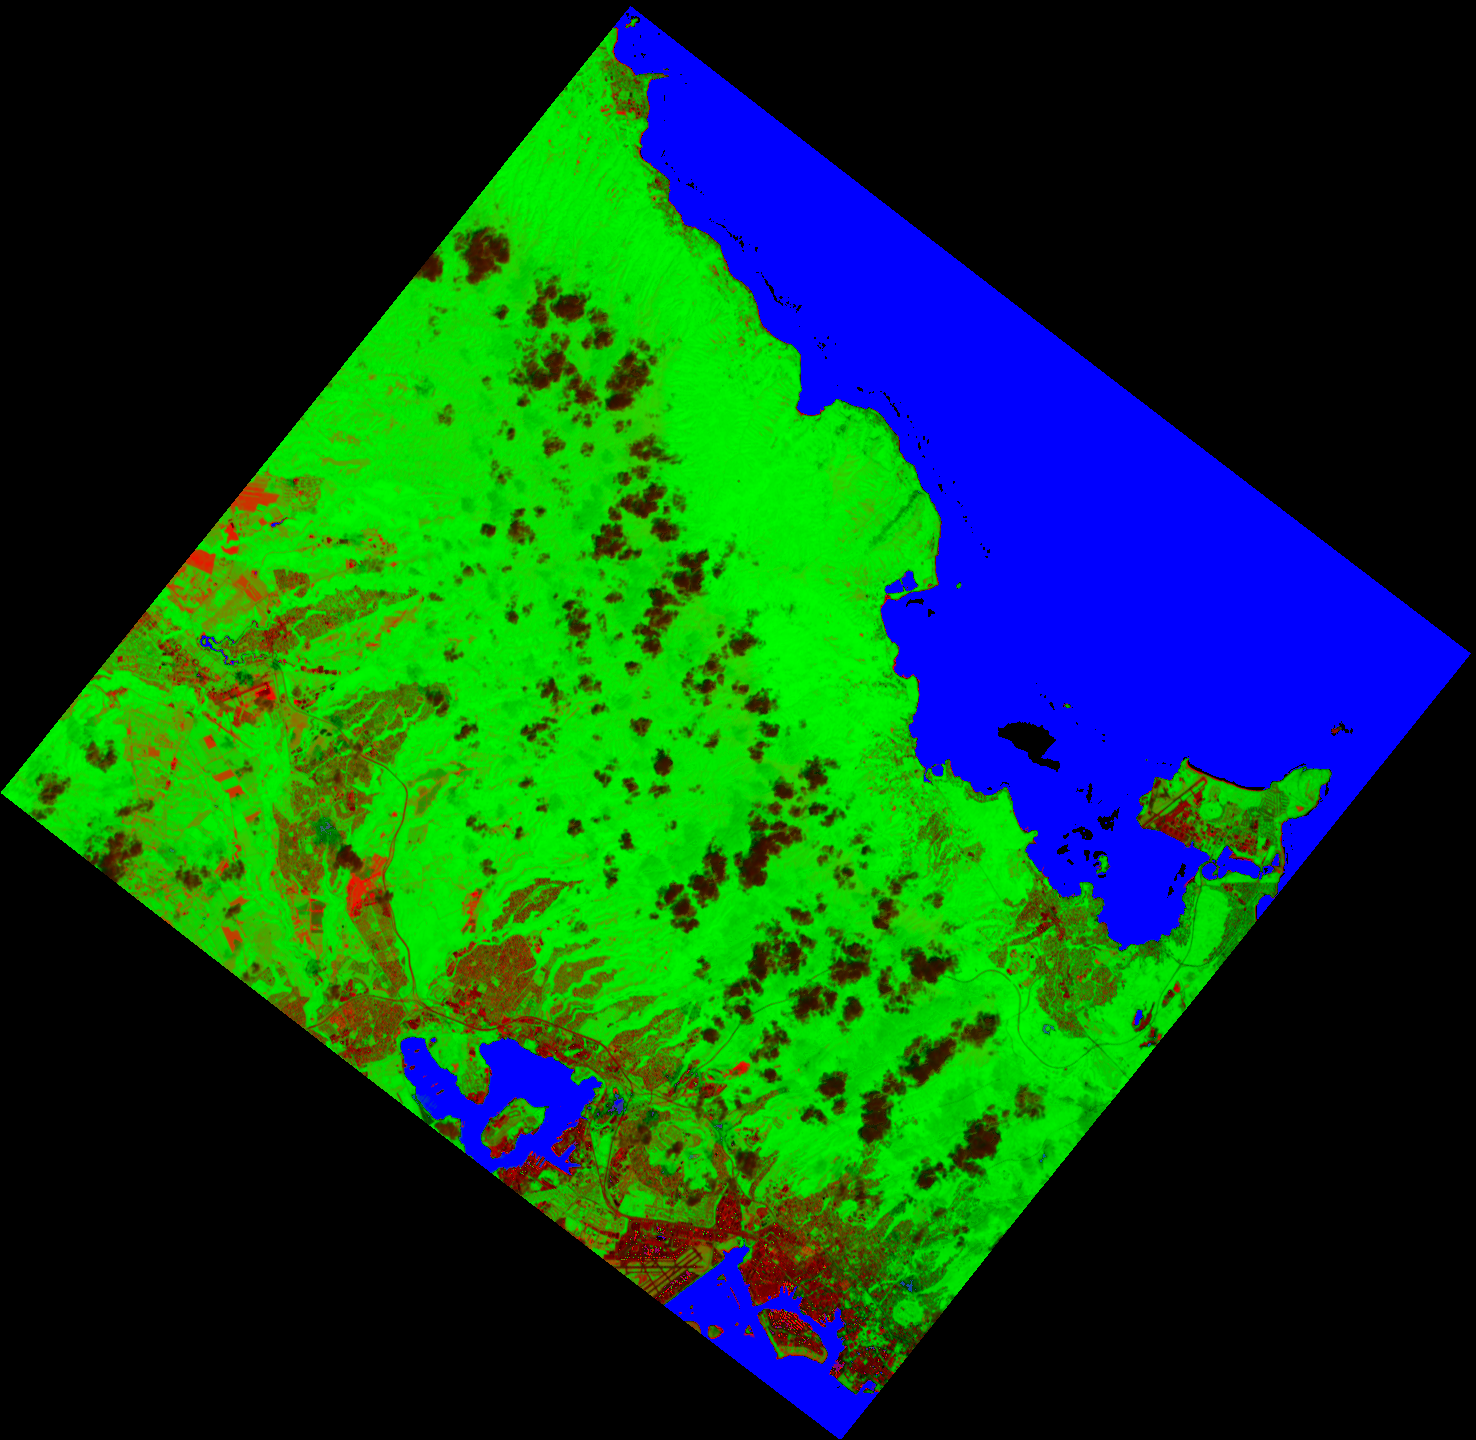

In [130]:
png = get_quicklook('7982573a-88f5-4705-b708-22241964b3e1')
IPython.display.Image(png)